In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from IPython import get_ipython
#get_ipython().run_line_magic('matplotlib', 'inline')


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Embedding
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
import tensorflow.keras.utils as ku
from numpy.random import seed
from keras import callbacks
from keras.callbacks import ModelCheckpoint

import nltk
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import re
from pandas.io.formats.style_render import DefaultDict
from functools import reduce
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:

data = pd.read_csv('WSJ.csv')
data["headline_length"] = data["Headline"].str.split().apply(len)
sid = SentimentIntensityAnalyzer()
data['scores'] = data['Headline'].apply(lambda headline: sid.polarity_scores(headline))
data['compound']  = data['scores'].apply(lambda score_dict: score_dict['compound'])
data['comp_score'] = data['compound'].apply(lambda c: 'positive' if c >=0.05 else ('negative' if c <= -0.05 else 'neutral'))
data.head()

,Date,Headline,Type,headline_length,scores,compound,comp_score
0,01/01/08,"PHH Ends Deal With Blackstone, GE",U.S. Business News,6,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
1,01/01/08,"Welcome, 2008",Infogrfx Slide Show,2,"{'neg': 0.0, 'neu': 0.25, 'pos': 0.75, 'compou...",0.4588,positive
2,01/01/08,Candidates Scramble to Reach Voters,Politics and Policy,5,"{'neg': 0.0, 'neu': 0.784, 'pos': 0.216, 'comp...",0.0258,neutral
3,01/01/08,Stocks Cap Wild Year With a Slip,Today's Markets,7,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
4,01/01/08,Qualcomm Loses Patent Dispute,U.S. Business News,4,"{'neg': 0.714, 'neu': 0.286, 'pos': 0.0, 'comp...",-0.6124,negative


In [5]:
def preprocess_passage(passage):
    tokens = word_tokenize(passage.lower())
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [re.sub(r'[^a-zA-Z]', '', token) for token in tokens if token not in stop_words]
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    sentence = ' '.join(lemmatized_tokens)
    return sentence

In [7]:
model_path = 'GoogleNews-vectors-negative300.bin.gz'
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format(model_path, binary=True)


In [8]:
categories = ["business economy", "politics", "entertainment sports"]
category_embeddings = {}

for category in categories:
    category_embeddings[category] = np.mean([model.get_vector(word) for word in category.split() if word in model.index_to_key], axis=0)


In [9]:
# Define a list of keys
keys = categories
# Initialize an empty dictionary with keys and default value of None
similarity = {key: None for key in keys}
# Print the resulting dictionary
print(similarity)

{'business economy': None, 'politics': None, 'entertainment sports': None}


In [14]:
data['headline_processed'] = data['Headline'].apply(preprocess_passage)
data_copy = data.copy()

In [16]:
from sklearn.metrics.pairwise import cosine_similarity

# Precompute headline vectors for all rows where possible
headline_vectors = []
for row in data['headline_processed']:
    headline_words = row.split()
    # Calculate the mean vector for all valid words in the headline
    vectors = [model.get_vector(word) for word in headline_words if word in model.index_to_key]
    headline_vector = np.mean(vectors, axis=0) if vectors else None
    headline_vectors.append(headline_vector)

# Convert category embeddings to a 2D array for bulk similarity computation
category_matrix = np.array([category_embeddings[cat] for cat in categories])

# Dictionary to store indices for each category
similarity = {cat: [] for cat in categories}

# Bulk computation of cosine similarities
for idx, headline_vector in enumerate(headline_vectors):
    if headline_vector is None or np.isnan(headline_vector).any():
        continue
    # Compute cosine similarities with all category vectors at once
    similarities = cosine_similarity(headline_vector.reshape(1, -1), category_matrix).flatten()
    # Find the category with the highest similarity
    max_category = categories[np.argmax(similarities)]
    similarity[max_category].append(idx)


In [17]:
len_total = 0
for category in categories:
    len_total = len_total + len(similarity[category])
    print(category,":", len(similarity[category]))

business economy : 89876
politics : 39968
entertainment sports : 27592


In [18]:
categorised_headlines = pd.DataFrame(similarity.items(), columns=['category', 'id'])

In [19]:
categorised_headlines = categorised_headlines.explode('id')
print(categorised_headlines.head(5))
print(categorised_headlines.shape)

           category id
0  business economy  0
0  business economy  3
0  business economy  6
0  business economy  7
0  business economy  8
(157436, 2)


In [20]:
categorised_headlines = categorised_headlines.reset_index(drop = True)
categorised_headlines.head()

,category,id
0,business economy,0
1,business economy,3
2,business economy,6
3,business economy,7
4,business economy,8


In [21]:
final_df = pd.merge(data_copy, categorised_headlines, left_index=True, right_on='id', how = "inner")
final_df = final_df.reset_index(drop = True)
final_df.head()

,Date,Headline,Type,headline_length,scores,compound,comp_score,headline_processed,category,id
0,01/01/08,"PHH Ends Deal With Blackstone, GE",U.S. Business News,6,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,phh end deal blackstone ge,business economy,0
1,01/01/08,"Welcome, 2008",Infogrfx Slide Show,2,"{'neg': 0.0, 'neu': 0.25, 'pos': 0.75, 'compou...",0.4588,positive,welcome,entertainment sports,1
2,01/01/08,Candidates Scramble to Reach Voters,Politics and Policy,5,"{'neg': 0.0, 'neu': 0.784, 'pos': 0.216, 'comp...",0.0258,neutral,candidate scramble reach voter,politics,2
3,01/01/08,Stocks Cap Wild Year With a Slip,Today's Markets,7,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,stock cap wild year slip,business economy,3
4,01/01/08,Qualcomm Loses Patent Dispute,U.S. Business News,4,"{'neg': 0.714, 'neu': 0.286, 'pos': 0.0, 'comp...",-0.6124,negative,qualcomm loses patent dispute,politics,4


In [22]:
final_df.to_csv('sentiment_using_vader.csv', index=False)

In [23]:
start_date = '2008-08-08'  # Start date
end_date = '2017-01-01'    # End date
# Generate a sequence of dates between start and end dates
date_range = pd.date_range(start=start_date, end=end_date)
# Create a dataframe with the date range as a new column
df = pd.DataFrame({'Date': date_range})
print(df)

           Date
0    2008-08-08
1    2008-08-09
2    2008-08-10
3    2008-08-11
4    2008-08-12
...         ...
3064 2016-12-28
3065 2016-12-29
3066 2016-12-30
3067 2016-12-31
3068 2017-01-01

[3069 rows x 1 columns]


In [24]:
sp500 = pd.read_csv("S_P500.csv")
sp500["Date"] = pd.to_datetime(sp500["Date"])
sp500 = pd.merge(df, sp500, how = "left", on = "Date")

nifty50 = pd.read_csv("NIFTY50_Index.csv")
nifty50_close = nifty50[["Date","NSEI.Close"]]
nifty50_close["Date"] = pd.to_datetime(nifty50_close["Date"])

ftse = pd.read_csv("FTSE_Index.csv")
ftse_close = ftse[["Date","FTSE.Close"]]
ftse_close["Date"] = pd.to_datetime(ftse_close["Date"])

nikkei = pd.read_csv("NIKKEI225_Index.csv")
nikkei_close = nikkei[["Date","N225.Close"]]
nikkei_close["Date"] = pd.to_datetime(nikkei_close["Date"])

dax = pd.read_csv("DAX_Index.csv")
dax_close = dax[["Date","GDAXI.Close"]]
dax_close["Date"] = pd.to_datetime(dax_close["Date"])

cac40 = pd.read_csv("CAC40_Index.csv")
cac40_close = cac40[["Date","FCHI.Close"]]
cac40_close["Date"] = pd.to_datetime(cac40_close["Date"])

cboe_volatility_index = pd.read_csv("CBOE_Volatility_Index.csv")
cboe_volatility_index_close = cboe_volatility_index[["Date","VIX.Close"]]
cboe_volatility_index_close["Date"] = pd.to_datetime(cboe_volatility_index_close["Date"])

data_frames = [sp500, ftse_close, nifty50_close, nikkei_close, dax_close, cac40_close,cboe_volatility_index_close]


<ipython-input-24-e8a00c55caef>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nifty50_close["Date"] = pd.to_datetime(nifty50_close["Date"])
<ipython-input-24-e8a00c55caef>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ftse_close["Date"] = pd.to_datetime(ftse_close["Date"])
<ipython-input-24-e8a00c55caef>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

In [25]:
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'],
                                            how='outer'), data_frames)
df_merged.head()

,Date,GSPC.Open,GSPC.High,GSPC.Low,GSPC.Close,GSPC.Volume,GSPC.Adjusted,FTSE.Close,NSEI.Close,N225.Close,GDAXI.Close,FCHI.Close,VIX.Close
0,2008-08-08,1266.290039,1297.849976,1262.109985,1296.319946,4.966810e+09,1296.319946,5489.200195,4529.500000,13168.410156,6561.649902,4491.850098,20.660000
1,2008-08-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2008-08-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2008-08-11,1294.420044,1313.150024,1291.410034,1305.319946,5.067310e+09,1305.319946,5541.799805,4620.399902,13430.910156,6609.629883,4538.490234,20.120001
4,2008-08-12,1304.790039,1304.790039,1285.640015,1289.589966,4.711290e+09,1289.589966,5534.500000,4552.250000,13303.599609,6585.870117,4518.479980,21.170000


In [26]:
df_merged = df_merged.sort_values('Date', ascending = True)
df_merged.fillna(method='ffill', inplace=True)

<ipython-input-26-62ad55312a33>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_merged.fillna(method='ffill', inplace=True)


In [27]:
df_merged['month_start_date'] = df_merged["Date"].dt.to_period('M').dt.to_timestamp() + pd.offsets.MonthBegin(0)

In [29]:
unemployment_rate = pd.read_csv("unemployment_rate.csv")
unemployment_rate["month_start_date"] = pd.to_datetime(unemployment_rate['DATE'])
df_merged = pd.merge(df_merged, unemployment_rate[["month_start_date","UNRATE"]], how = 'left', on = "month_start_date")


federal_funds_rate = pd.read_csv("federal_funds_rate.csv")
federal_funds_rate["Date"] = pd.to_datetime(federal_funds_rate['DATE'])
df_merged = pd.merge(df_merged, federal_funds_rate[["Date","DFF"]], how = 'left', on = "Date")


consumer_sentiment = pd.read_csv("consumer_sentiment_index.csv")
consumer_sentiment["month_start_date"] = pd.to_datetime(consumer_sentiment['DATE'])
df_merged = pd.merge(df_merged, consumer_sentiment[["month_start_date","UMCSENT"]], how = 'left', on = "month_start_date")

df_merged =df_merged.drop(["month_start_date"], axis = 1)
df_merged.to_csv("X_features.csv", index = False)



In [ ]:
# # LSTM model

tech_ind = pd.read_csv("X_features.csv") #df_merged
vader = pd.read_csv("sentiment_using_vader.csv", engine="python")


# # Technical indicators

vader['Date'] = pd.to_datetime(vader['Date'])
tech_ind['Date'] = pd.to_datetime(tech_ind['Date'])

headlines_businessecopol = vader[(vader['category']=='business economy') | (vader['category']=='politics')]
headlines_businesseco = vader[vader['category']=='business economy']
headlines_all = vader

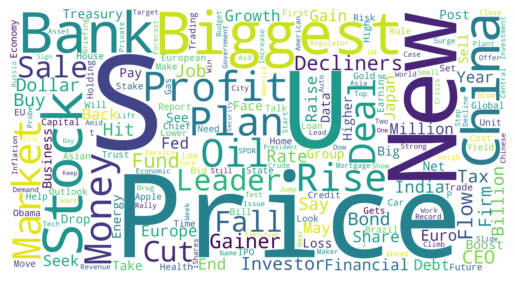

In [33]:
# # Visualizations
import pandas as pd
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from wordcloud import WordCloud

df1 = vader.loc[vader["category"]=="business economy"]
df2 = vader.loc[vader["category"]=="politics"]
df3 = vader.loc[vader["category"]=="entertainment sports"]

text1 = " ".join(title for title in df1.Headline)
# Creating word_cloud with text as argument in .generate() method

word_cloud1 = WordCloud(collocations = False, background_color = 'white',
                        width = 2048, height = 1080).generate(text1)
# saving the image
word_cloud1.to_file('got.png')
# Display the generated Word Cloud

plt.imshow(word_cloud1, interpolation='bilinear')
plt.axis("off")
plt.show()


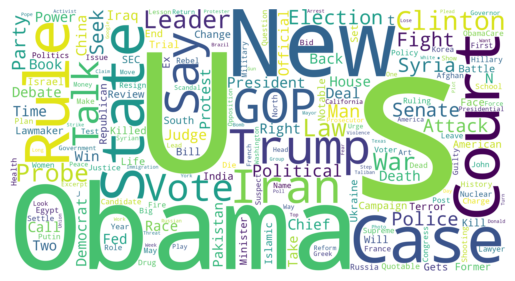

In [34]:
text2 = " ".join(title for title in df2.Headline)
# Creating word_cloud with text as argument in .generate() method

word_cloud2 = WordCloud(collocations = False, background_color = 'white',
                        width = 2048, height = 1080).generate(text2)
# saving the image
word_cloud2.to_file('got2.png')
# Display the generated Word Cloud

plt.imshow(word_cloud2, interpolation='bilinear')
plt.axis("off")
plt.show()


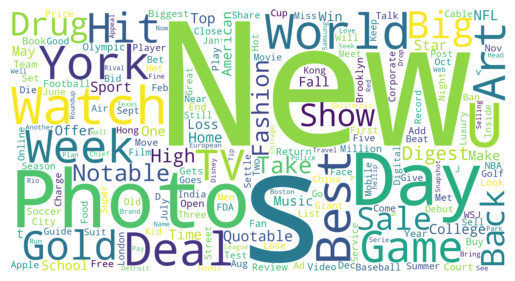

In [35]:
text3 = " ".join(title for title in df3.Headline)
# Creating word_cloud with text as argument in .generate() method

word_cloud3 = WordCloud(collocations = False, background_color = 'white',
                        width = 2048, height = 1080).generate(text3)
# saving the image
word_cloud3.to_file('got3.png')
# Display the generated Word Cloud

plt.imshow(word_cloud3, interpolation='bilinear')
plt.axis("off")
plt.show()

In [38]:
def create_dataset_for_model(tech_ind, headlines_selected, sentiment_presence=True):

    vader_sentiments = pd.DataFrame(headlines_selected.groupby('Date')['comp_score'].apply(list).reset_index())
    tech_ind = tech_ind.merge(vader_sentiments, on='Date', how='left')
    tech_ind['comp_score'] = tech_ind['comp_score'].fillna(method='ffill')

    #macd
    tech_ind['ema_26'] = tech_ind['GSPC.Close'].ewm(span=26).mean()
    tech_ind['ema_12'] = tech_ind['GSPC.Close'].ewm(span=12).mean()
    tech_ind['macd'] = tech_ind['ema_12']  - tech_ind['ema_26']

    # daily return
    tech_ind['daily_return'] = tech_ind['GSPC.Close'].pct_change().fillna(0)

    # moving avg 5days
    tech_ind['moving_avg5'] = tech_ind['GSPC.Close'].rolling(window=5).mean()

    # moving avg 10days
    tech_ind['moving_avg10'] = tech_ind['GSPC.Close'].rolling(window=10).mean()

    # bollinger high and bollinger low
    window = 21
    no_of_std = 2
    rolling_mean = tech_ind['GSPC.Close'].rolling(window).mean()
    rolling_std = tech_ind['GSPC.Close'].rolling(window).std()
    tech_ind['bb_high'] = (rolling_mean + (rolling_std*no_of_std)).fillna(0)
    tech_ind['bb_low'] = (rolling_mean - (rolling_std*no_of_std)).fillna(0)

    # sentiment proportion
    tech_ind['sentiment_proportion'] = tech_ind['comp_score'].apply(lambda x: x.count('positive')/len(x))

    # moving avg of sentiments
    tech_ind['moving_avg_sentiment'] = tech_ind['sentiment_proportion'].rolling(window=3).mean()

    # rsi
    change = tech_ind["GSPC.Close"].diff()
    change.dropna(inplace=True)

    # Create two copies of the Closing price Series
    change_up = change.copy()
    change_down = change.copy()
    change_up[change_up<0] = 0
    change_down[change_down>0] = 0

    # Verify that we did not make any mistakes
    change.equals(change_up+change_down)

    # Calculate the rolling average of average up and average down
    avg_up = change_up.rolling(14).mean()
    avg_down = change_down.rolling(14).mean().abs()

    rsi = 100 * avg_up / (avg_up + avg_down)
    tech_ind['rsi'] = rsi

    tech_ind['y'] = tech_ind['GSPC.Close']

    if sentiment_presence:
        dataset = tech_ind[['FTSE.Close',
           'NSEI.Close', 'N225.Close', 'GDAXI.Close', 'FCHI.Close', 'VIX.Close', 'UMCSENT', 'moving_avg5', 'moving_avg10', 'UNRATE',
               'DFF','macd', 'daily_return', 'bb_high', 'bb_low', 'rsi', 'sentiment_proportion', 'moving_avg_sentiment', 'GSPC.Close', 'y']]

    else:
        dataset = tech_ind[['FTSE.Close',
               'NSEI.Close', 'N225.Close', 'GDAXI.Close', 'FCHI.Close', 'UNRATE',
               'DFF', 'VIX.Close', 'UMCSENT', 'moving_avg5', 'moving_avg10',
               'macd', 'daily_return', 'bb_high', 'bb_low', 'rsi' , 'GSPC.Close', 'y']] #'sentiment_proportion', 'moving_avg_sentiment','

    dataset = dataset.fillna(0)

    return dataset


In [39]:
# dataset = create_dataset_for_model(tech_ind, headlines_all, sentiment_presence=True)
# dataset = create_dataset_for_model(tech_ind, headlines_all, sentiment_presence=False)
# dataset = create_dataset_for_model(tech_ind, headlines_businesseco, sentiment_presence=True)
dataset = create_dataset_for_model(tech_ind, headlines_businessecopol, sentiment_presence=True)

<ipython-input-38-6ba0b844dfc8>:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tech_ind['comp_score'] = tech_ind['comp_score'].fillna(method='ffill')


In [40]:
def scale(data):
    X = data.loc[ : , data.columns != 'y']
    y = np.array(data['y']).reshape(-1, 1)

    X_scaler = MinMaxScaler().fit(X)
    X_scaled = X_scaler.transform(X)
    y_scaler = MinMaxScaler().fit(y)
    y_scaled = y_scaler.transform(y)

    data_scaled = np.concatenate([X_scaled,y_scaled], axis=1)

    return pd.DataFrame(data_scaled), X_scaler, y_scaler


In [41]:
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    r = len(dataset)-look_back
    for i in range(r):
        a = dataset.iloc[i:(i+look_back),:-1]
        dataX.append(a)
        b = dataset.iloc[i+look_back,-1]
        dataY.append(b)
    return np.array(dataX), np.array(dataY)


In [42]:
size_60percent = int(0.6*len(dataset))
size_20percent = int(0.2*len(dataset))

train = dataset[:size_60percent]
valid = dataset[size_60percent:size_60percent+size_20percent]
test = dataset[size_60percent+size_20percent:]

train, X_scaler_train, y_scaler_train = scale(train)
valid, X_scaler_valid, y_scaler_valid = scale(valid)
test, X_scaler_test, y_scaler_test = scale(test)

print('Length of training set = {} and Length of validation set = {} and Length of test set = {}'.format(len(train), len(valid), len(test)))
X_train, y_train = create_dataset(train, look_back=10)
X_valid, y_valid = create_dataset(valid, look_back=10)
X_test, y_test = create_dataset(test, look_back=10)


Length of training set = 1841 and Length of validation set = 613 and Length of test set = 615


In [46]:
 # Model definition

def create_lstm(X_train, dropout):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam',  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model


def fit_lstm(model, X_train, y_train, X_valid, y_valid, batch_size, num_epochs):

    y_train = np.expand_dims(y_train, axis=1)
    y_valid = np.expand_dims(y_valid, axis=1)

    earlystopping = [callbacks.EarlyStopping(monitor ="loss", mode ="min", patience = 10, restore_best_weights = True, verbose=1),
     ModelCheckpoint(filepath='best_model.keras', monitor='loss', save_best_only=True)]

    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data = (X_valid,y_valid),
                  callbacks =[earlystopping], shuffle=False, verbose=1)
    return model, history



In [47]:
tf.config.run_functions_eagerly(True)


In [48]:
# [samples, time steps, features]
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

batchs = [64]
epochs = [10]
dropout = [0.2,0.3]
histories = dict()
train_rmse = []
test_rmse = []
train_mae = []
test_mae = []
train_mape = []
test_mape = []
trainPredict_values = []
validPredict_values = []

for epoch_value in epochs:
    for batch_value in batchs:
        for dropout_value in dropout:

            print('')
            print('')
            print('FOR BATCH SIZE = {} AND NUMBER OF EPOCHS = {} AND DROPOUT = {}'.format(batch_value,epoch_value, dropout_value))

            model = create_lstm(X_train, dropout_value)
            model, history = fit_lstm(model, X_train, y_train, X_valid, y_valid, batch_size=batch_value, num_epochs=epoch_value)
            histories[(epoch_value, batch_value, dropout_value)] =  [model, history]

            # make predictions
            trainPredict = model.predict(X_train)
            validPredict = model.predict(X_valid)

            #invert predictions
            trainPredict = y_scaler_train.inverse_transform(trainPredict)
            validPredict = y_scaler_valid.inverse_transform(validPredict)
            y_train_inv = y_scaler_train.inverse_transform([y_train])
            y_valid_inv = y_scaler_valid.inverse_transform([y_valid])

            trainPredict = trainPredict.reshape(1,-1)
            validPredict = validPredict.reshape(1,-1)

            trainPredict_values.append(trainPredict)
            validPredict_values.append(validPredict)

            # evaluation metrics
            train_rmse.append(np.sqrt(mean_squared_error(y_train_inv, trainPredict)))
            test_rmse.append(np.sqrt(mean_squared_error(y_valid_inv, validPredict)))
            train_mae.append(mean_absolute_error(y_train_inv, trainPredict))
            test_mae.append(mean_absolute_error(y_valid_inv, validPredict))
            train_mape.append(mean_absolute_percentage_error(y_train_inv, trainPredict))
            test_mape.append(mean_absolute_percentage_error(y_valid_inv, validPredict))





FOR BATCH SIZE = 64 AND NUMBER OF EPOCHS = 10 AND DROPOUT = 0.2
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 477ms/step - loss: 0.0616 - root_mean_squared_error: 0.2292 - val_loss: 0.0168 - val_root_mean_squared_error: 0.1297
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 336ms/step - loss: 0.0061 - root_mean_squared_error: 0.0762 - val_loss: 0.0158 - val_root_mean_squared_error: 0.1257
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 356ms/step - loss: 0.0077 - root_mean_squared_error: 0.0875 - val_loss: 0.0219 - val_root_mean_squared_error: 0.1481
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 327ms/step - loss: 0.0102 - root_mean_squared_error: 0.1004 - val_loss: 0.0333 - val_root_mean_squared_error: 0.1824
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 319ms/step - loss: 0.0103 - root_mean_squared_error: 0.0998 - val_loss: 0.0513 - val_root_mean_squared_error: 0.2266
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 311ms/step - loss: 0.0031 - root_mean_squared_error: 0.0541 - val_loss: 0.0195 - val_root_mean_squared_error: 0.1398
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 264ms/step - loss

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 324ms/step - loss: 0.0421 - root_mean_squared_error: 0.1922 - val_loss: 0.0230 - val_root_mean_squared_error: 0.1518
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 363ms/step - loss: 0.0108 - root_mean_squared_error: 0.1033 - val_loss: 0.0357 - val_root_mean_squared_error: 0.1889
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 292ms/step - loss: 0.0120 - root_mean_squared_error: 0.1087 - val_loss: 0.0380 - val_root_mean_squared_error: 0.1949
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 382ms/step - loss: 0.0041 - root_mean_squared_error: 0.0628 - val_loss: 0.0168 - val_root_mean_squared_error: 0.1298
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 363ms/step - loss: 0.0110 - root_mean_squared_error: 0.1033 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1209
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 308ms/step - loss: 0.0118 - root_mean_squared_error: 0.1076 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1124
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 326ms/step - loss:

In [49]:
def get_best_hyperparameters(histories, valid_rmse, valid_mae, valid_mape):

    rmse_index = valid_rmse.index(min(valid_rmse))
    mae_index = valid_mae.index(min(valid_mae))
    mape_index = valid_mape.index(min(valid_mape))

    keys = list(histories.keys())

    rmse_epoch, rmse_batch, rmse_dropout  = keys[rmse_index][0], keys[rmse_index][1], keys[rmse_index][2]
    mae_epoch, mae_batch, mae_dropout = keys[mae_index][0], keys[mae_index][1], keys[mae_index][2]
    mape_epoch, mape_batch, mape_dropout = keys[mape_index][0], keys[mape_index][1], keys[mape_index][2]

    print('Hyperparameters with lowest test rmse are batch size = {} and number of epochs = {} and dropout value = {}'.format(rmse_batch, rmse_epoch, rmse_dropout))
    print('Hyperparameters with lowest test mae are batch size = {} and number of epochs = {} and dropout value = {}'.format(mae_batch, mae_epoch, mae_dropout))
    print('Hyperparameters with lowest test mape are batch size = {} and number of epochs = {} and dropout value = {}'.format(mape_batch, mape_epoch, mape_dropout))

get_best_hyperparameters(histories, test_rmse, test_mae, test_mape)



Hyperparameters with lowest test rmse are batch size = 64 and number of epochs = 10 and dropout value = 0.2
Hyperparameters with lowest test mae are batch size = 64 and number of epochs = 10 and dropout value = 0.2
Hyperparameters with lowest test mape are batch size = 64 and number of epochs = 10 and dropout value = 0.2


In [50]:
best_epoch_value = 10
best_batch_value = 64
best_dropout_value = 0.2
best_index = list(histories.keys()).index((best_epoch_value,best_batch_value,best_dropout_value))
trainPredict_final = trainPredict_values[best_index]
validPredict_final = validPredict_values[best_index]

print('RMSE = {}, MAE = {}, MAPE = {}'.format(test_rmse[best_index], test_mae[best_index], test_mape[best_index]))


RMSE = 61.26150425964525, MAE = 49.29477286089085, MAPE = 0.02517998159618884


In [52]:
best_model = histories[(best_epoch_value, best_batch_value, best_dropout_value)][0]
best_model.save("model_all_w_sent.h5",overwrite=True)
best_model.save_weights('model_weights_all_w_sent.weights.h5', overwrite=True)


In [53]:
# # Evaluation
history = histories[(best_epoch_value, best_batch_value, best_dropout_value)][1]
print(history.history["loss"])
print(history.history["val_loss"])

[0.023639651015400887, 0.004200555384159088, 0.0068839313462376595, 0.011687660589814186, 0.01450042799115181, 0.005573158152401447, 0.0065042306669056416, 0.010700752958655357, 0.006501791067421436, 0.01178258191794157]
[0.016824327409267426, 0.015810398384928703, 0.021924568340182304, 0.03327663242816925, 0.051346682012081146, 0.01953321509063244, 0.01381529588252306, 0.016914164647459984, 0.008457403630018234, 0.007174436468631029]


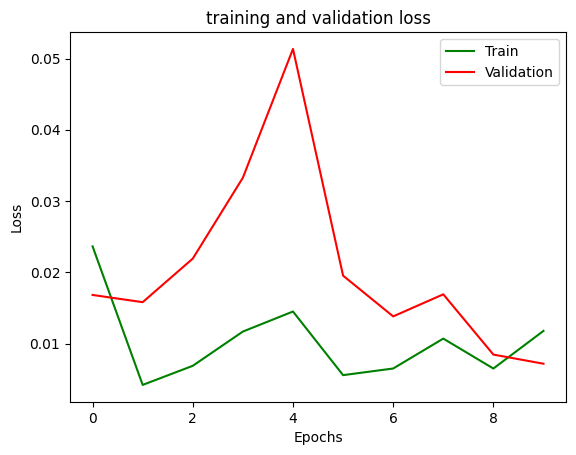

In [54]:
#history_dict = best_model.history.history
plt.plot(history.history["loss"], label='Train', color='green')
plt.plot(history.history["val_loss"], label='Validation', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('training and validation loss')
plt.show()


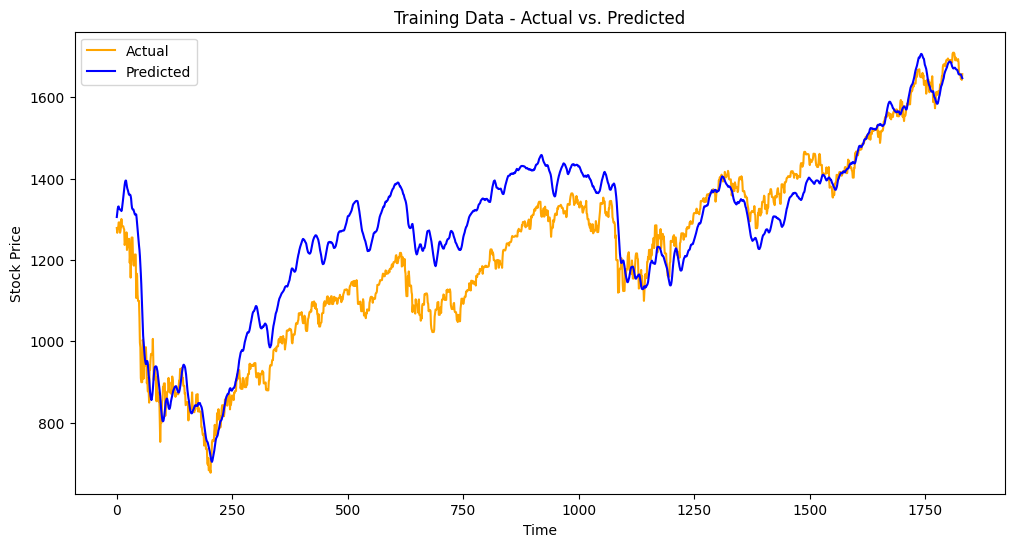

In [55]:
# Visualise results: how well the model is capturing the trends in the data.

# Training data
plt.figure(figsize=(12, 6))
plt.plot(y_train_inv.reshape(-1,1), label='Actual', color='orange')
plt.plot(trainPredict_final.reshape(-1,1), label='Predicted', color ='blue')
plt.title("Training Data - Actual vs. Predicted")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()



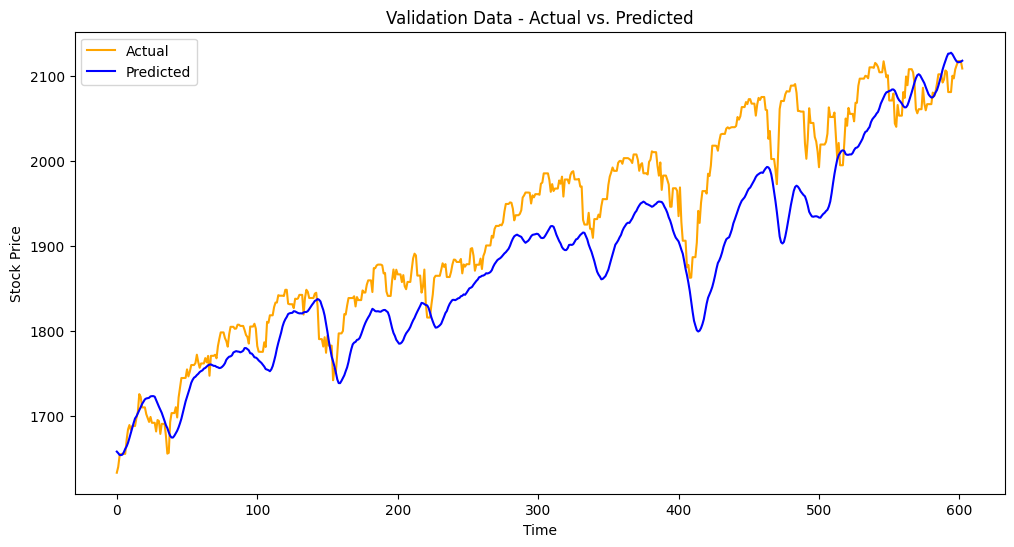

In [56]:
# Validation data
plt.figure(figsize=(12, 6))
plt.plot(y_valid_inv.reshape(-1,1), label='Actual', color='orange')
plt.plot(validPredict_final.reshape(-1,1), label='Predicted', color ='blue')
plt.title("Validation Data - Actual vs. Predicted")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


In [57]:
# Plotting residuals
# Calculate residuals for train and test sets

trainPredict1 = np.squeeze(trainPredict_final)
validPredict1 = np.squeeze(validPredict_final)

residuals_train = y_train_inv.reshape(-1,1) - trainPredict1.reshape(-1,1)
residuals_valid = y_valid_inv.reshape(-1,1) - validPredict1.reshape(-1,1)


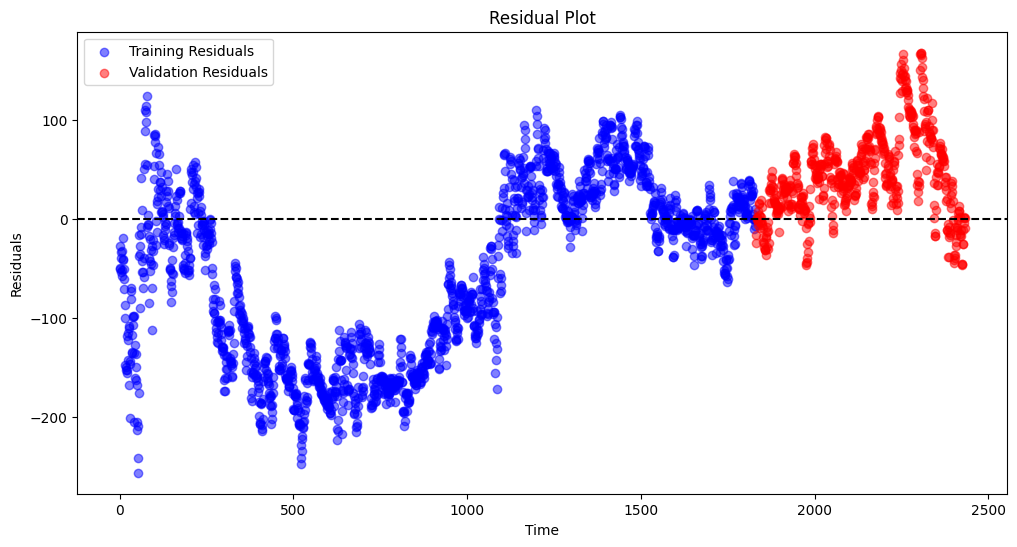

In [58]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.scatter(range(len(residuals_train)), residuals_train, label='Training Residuals', color='blue', alpha=0.5)
plt.scatter(range(len(residuals_train), len(residuals_train) + len(residuals_valid)), residuals_valid, label='Validation Residuals', color='red', alpha=0.5)
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.legend()
plt.show()


In [59]:
testPredict = best_model.predict(X_test)
testPredict = y_scaler_test.inverse_transform(testPredict)
testPredict = testPredict.reshape(1,-1)

#invert predictions
y_test_inv = y_scaler_test.inverse_transform([y_test])



 1/19 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step


In [60]:
def get_forecasting_plot(pred_train, pred_valid, pred_test):
    global y_train_inv, y_valid_inv, y_test_inv

    plt.figure(figsize=(12, 6))

    # Ensure that the input arrays have the same dimensions
    y_train_inv_flat = y_train_inv.reshape(-1)
    pred_train_flat = pred_train.reshape(-1)
    y_valid_inv_flat = y_valid_inv.reshape(-1)
    pred_valid_flat = pred_valid.reshape(-1)
    y_test_inv_flat = y_test_inv.reshape(-1)
    pred_test_flat = pred_test.reshape(-1)

    # Training data
    train_range = np.arange(len(y_train_inv_flat))
    plt.plot(train_range, y_train_inv_flat, label='Train Actual', color='orange')
    plt.plot(train_range, pred_train_flat, label='Train Predicted', color ='blue')

    # Validation data
    valid_range = np.arange(len(y_train_inv_flat), len(y_train_inv_flat) + len(y_valid_inv_flat))
    plt.plot(valid_range, y_valid_inv_flat, label='Validation Actual', color='magenta')
    plt.plot(valid_range, pred_valid_flat, label='Validation Predicted', color ='cyan')

    # Test data
    test_range = np.arange(len(y_train_inv_flat) + len(y_valid_inv_flat), len(y_train_inv_flat) + len(y_valid_inv_flat) + len(y_test_inv_flat))
    plt.plot(test_range, y_test_inv_flat, label='Test Actual', color='green')
    plt.plot(test_range, pred_test_flat, label='Test Predicted', color ='red')

    plt.title("Actual and Predicted forecasting")
    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.show()

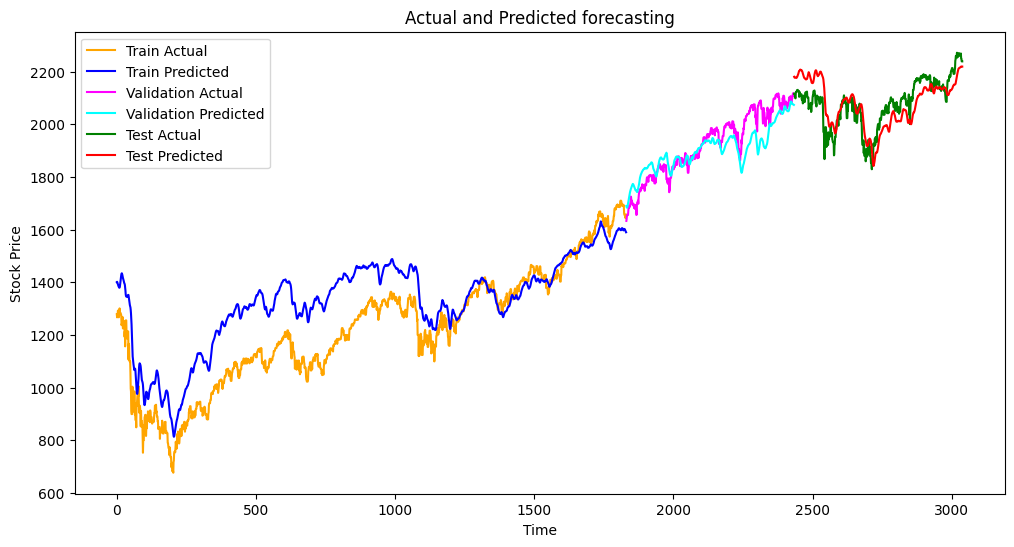

In [61]:
get_forecasting_plot(trainPredict, validPredict, testPredict)
